# <center>Welcome FSP solved with local search based metaheuristics</center>

This notebook presents a practical approach to solving the flowshop problem by implementing well-known local search based metaheuristics. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, local search metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions

# Table of Contents

1. [Data utils](#Data-utils)
2. [Neighborhood generation](#Neighborhood-generation)
3. [Local Based Metaheuristics](#Local-Based-Metaheuristics)
4. [Tests](#Tests)
<!-- 2. 1. [SWAP](#SWAP)
4. [Random SWAP](#Random-SWAP)
5. [Best SWAP](#Best-SWAP)
6. [First Admissible SWAP](#First-Admissible-SWAP)
7. [First and Best Admissible SWAP](#First-and-Best-Admissible-SWAP) -->

## Data utils

In [3]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from utils.benchmarks import benchmarks, upper_bound
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.utils import read_flow_shop_data

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [4]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Random data for tests

In [5]:
nb_jobs = 20
nb_machines = 5

In [6]:
rnd_data = np.random.randint(size=(nb_jobs,nb_machines), low=5, high=120)
permutation = np.random.permutation(nb_jobs).tolist()
print(rnd_data, "\n")
print('Initial solution:', permutation, "\n")

Cmax = calculate_makespan(rnd_data, permutation)
print(f'Makespan: {Cmax}')

[[110  31   8   8 119]
 [ 65  58  47  72  68]
 [ 39 103  29  98  76]
 [ 80  86 106   8  88]
 [ 97  42  23  33  99]
 [ 74  92  80 115  26]
 [ 58  27  79  71  26]
 [ 31  94 103  78 107]
 [ 51 100  93  56  53]
 [ 40   8  70 102  53]
 [ 95 112 100  29  45]
 [119  12  92  90  43]
 [ 58  86 100 117  20]
 [ 93  34  75  88  40]
 [ 90  12  92  88 115]
 [ 85  20  34  49  26]
 [ 59  42  82  35  40]
 [ 82  71  65  73 114]
 [102  47 103  60  55]
 [ 99   5 110  80  20]] 

Initial solution: [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4] 

Makespan: 2015


### Gantt graph generator

In [7]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

### INITIAL SOLUTION METHODS

In [8]:
from utils.initial_sol_methods import neh_algorithm
from utils.initial_sol_methods import PRSKE
from utils.initial_sol_methods import ham_heuristic

## Neighborhood generation

### SWAP

In [9]:
def swap(solution, i, k):
    sol = solution.copy()
    sol[i], sol[k] = sol[k], sol[i]
    return sol

### Random SWAP

In [10]:
def random_swap(solution, processing_times):
    i = random.choice(list(solution))
    j = random.choice(list(solution))

    while i == j:
        j = random.choice(list(solution))

    new_solution = swap(solution, i, j)
    
    return new_solution, calculate_makespan(processing_times, new_solution)

In [11]:
neighbor_sol, neighbor_cmax = random_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]
Cmax =  2015

Neighbor_solution:  [8, 3, 7, 13, 0, 10, 6, 17, 19, 18, 15, 2, 14, 5, 16, 9, 12, 11, 1, 4]
Neighor_cmax =  2022


### Best SWAP

In [12]:
def best_swap(solution, processing_times):
    sequence = solution.copy()
    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(sequence, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                sequence = new_solution
                Cmax = makespan

    return sequence, Cmax

In [13]:
neighbor_sol, neighbor_cmax = best_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]
Cmax =  2015

Neighbor_solution:  [9, 12, 7, 1, 2, 14, 8, 17, 4, 18, 10, 3, 19, 5, 11, 0, 15, 13, 6, 16]
Neighor_cmax =  1757


### First Admissible SWAP

In [14]:
def first_admissible_swap(solution, processing_times):

    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                return new_solution, makespan

    return solution, Cmax 

In [15]:
neighbor_sol, neighbor_cmax = first_admissible_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]
Cmax =  2015

Neighbor_solution:  [2, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 8, 10, 5, 16, 9, 12, 11, 1, 4]
Neighor_cmax =  2012


### First and Best Admissible SWAP

In [16]:
def fba_swap(solution, processing_times, best_global_sol):
    sequence = solution.copy()
    num_jobs = len(sequence)
    Cmax = calculate_makespan(processing_times, sequence)
    Smax = calculate_makespan(processing_times, best_global_sol)
    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            # First improving solution
            if makespan < Cmax:
                # Improves the global solution
                if makespan < Smax:
                    return new_solution, makespan, new_solution 
                Cmax = makespan
                sequence = new_solution                

    return sequence, Cmax, best_global_sol 

In [17]:
best_global = np.random.permutation(nb_jobs).tolist()

while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

neighbor_sol, neighbor_cmax, best_global_found = fba_swap(permutation, rnd_data, best_global)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nBest_original_global_solution: ", best_global)
print("Best_global_initial_cmax = ", calculate_makespan(rnd_data, best_global))

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

print("\nBest_global_solution: ", best_global_found)
print("Best_global_cmax = ", calculate_makespan(rnd_data, best_global_found))

Original_solution:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]
Cmax =  2015

Best_original_global_solution:  [13, 15, 7, 4, 5, 8, 2, 14, 16, 19, 12, 11, 3, 6, 1, 0, 9, 17, 18, 10]
Best_global_initial_cmax =  1962

Neighbor_solution:  [8, 3, 7, 12, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 13, 11, 1, 4]
Neighor_cmax =  1951

Best_global_solution:  [8, 3, 7, 12, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 13, 11, 1, 4]
Best_global_cmax =  1951


## Local Based Metaheuristics

### Simulated annealing (RS) 

#### General method to get neighbors (except first and best admissible)

In [18]:
def get_neighbor(processing_times, solution, method='random_swap'):
    if method == 'random_swap':
        sol, val = random_swap(solution, processing_times)
    elif method == 'best_swap':
        sol, val = best_swap(solution, processing_times)
    elif method == 'first_admissible_swap':
        sol, val = first_admissible_swap(solution, processing_times)
    else:
        i = random.randint(0, 2)
        if i == 0:
            sol, val = random_swap(solution, processing_times)
        elif i == 1:
            sol, val = best_swap(solution, processing_times)
        elif i == 2:
            sol, val = first_admissible_swap(solution, processing_times)
    return sol, val

In [19]:
def RS(processing_times, initial_solution, temp, method='random_swap', alpha=0.6, nb_palier= 10, it_max=100):
    
    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan, "\n")
    it = 0
    while it < it_max:
        for i in range(nb_palier):
            sol, value = get_neighbor(processing_times, solution, method)
            # print('Swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds")
    return solution

### RS with first and best admissible swap 

In [20]:
def RS_fba(processing_times, initial_solution, intitial_global, temp, alpha=0.6, nb_palier= 1, it_max=100):


    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan)
    it = 0
    print('initial_global_solution: ',intitial_global, ' global_makespan = ', calculate_makespan(processing_times, intitial_global), "\n")
    best_global = intitial_global.copy()
    while it < it_max :
        for i in range(nb_palier):
            sol, value, best_global = fba_swap(solution, processing_times, best_global)
            # print('FBA_swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds")
    return solution, best_global

### Finding optimal params

In [21]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

In [22]:
# Définir l'espace des paramètres
space = [
    Real(0.5, 0.9, name='alpha'),
    Integer(5, 20, name='nb_palier'),
    Integer(50, 200, name='it_max')
]

processing_times = benchmark
initial_solution = permutation
# Fonction objectif à minimiser
@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    nb_palier = params['nb_palier']
    it_max = params['it_max']
    # Vous devez définir `processing_times` et `initial_solution`
    result = RS(processing_times, initial_solution, temp=100, alpha=alpha, nb_palier=nb_palier, it_max=it_max)
    return calculate_makespan(processing_times, result)

# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=50, random_state=0)
# Affichage des meilleurs paramètres trouvés
print("Meilleurs paramètres: alpha={}, nb_palier={}, it_max={}".format(
    result.x[0], result.x[1], result.x[2]))

init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.25723910331726074 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.1635303497314453 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.045683860778808594 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 



Elapsed time: 0.17437124252319336 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.15201640129089355 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.18673229217529297 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.17679500579833984 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.15626811981201172 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.14670801162719727 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.07532739639282227 seconds
init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan = 

## Tests

We can adjust the swapping method to see the differences in tests

In [23]:
optimal_alpha = result.x[0]
optimal_Nb_palier = result.x[1]
optimal__it_max = result.x[2]
best_global = np.random.permutation(nb_jobs).tolist()
while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

### Random initial solution

#### Without FBA swapping method

In [24]:
rs_solution = RS(benchmark, permutation, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516 

Elapsed time: 0.3010270595550537 seconds


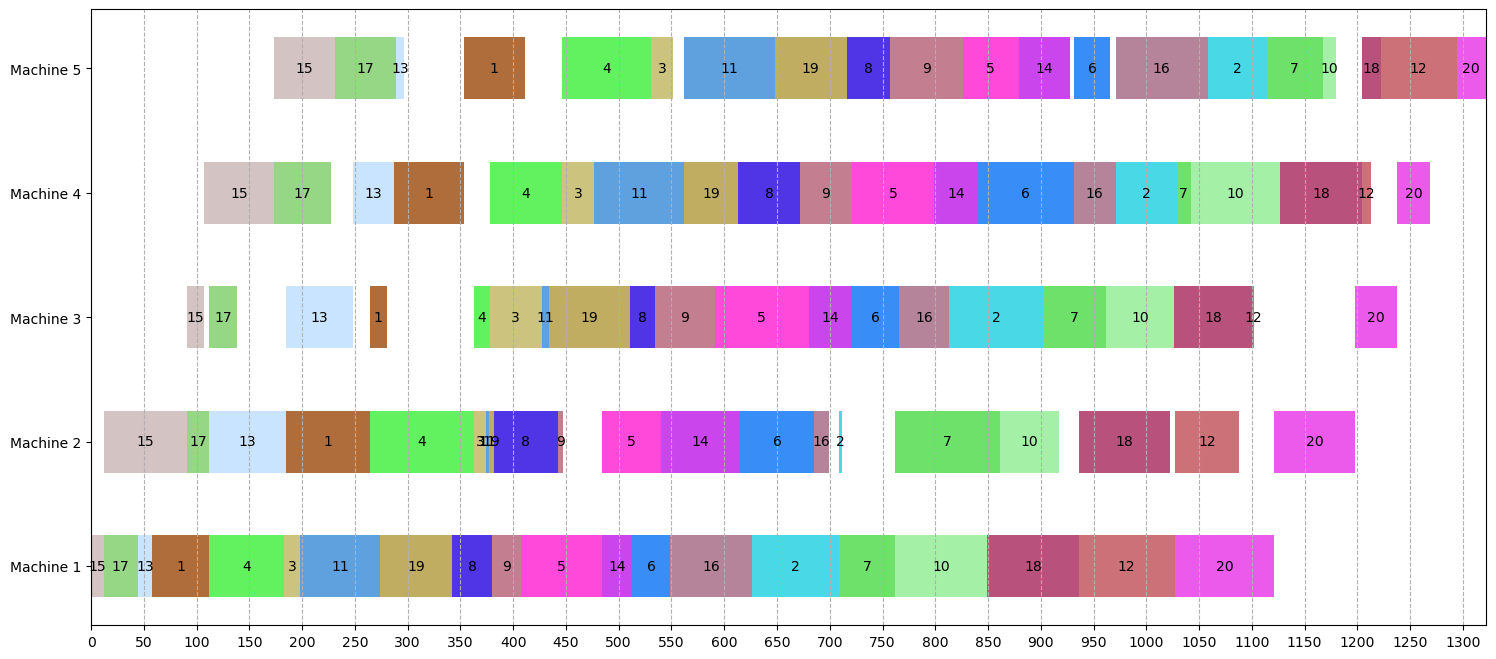

In [25]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [26]:
rs_fba_solution, best_global_found = RS_fba(benchmark, permutation, best_global, 5,alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4]  makespan =  1516
initial_global_solution:  [6, 8, 16, 7, 12, 19, 17, 14, 9, 1, 10, 2, 11, 4, 0, 15, 3, 5, 13, 18]  global_makespan =  1523 

Elapsed time: 45.01194977760315 seconds


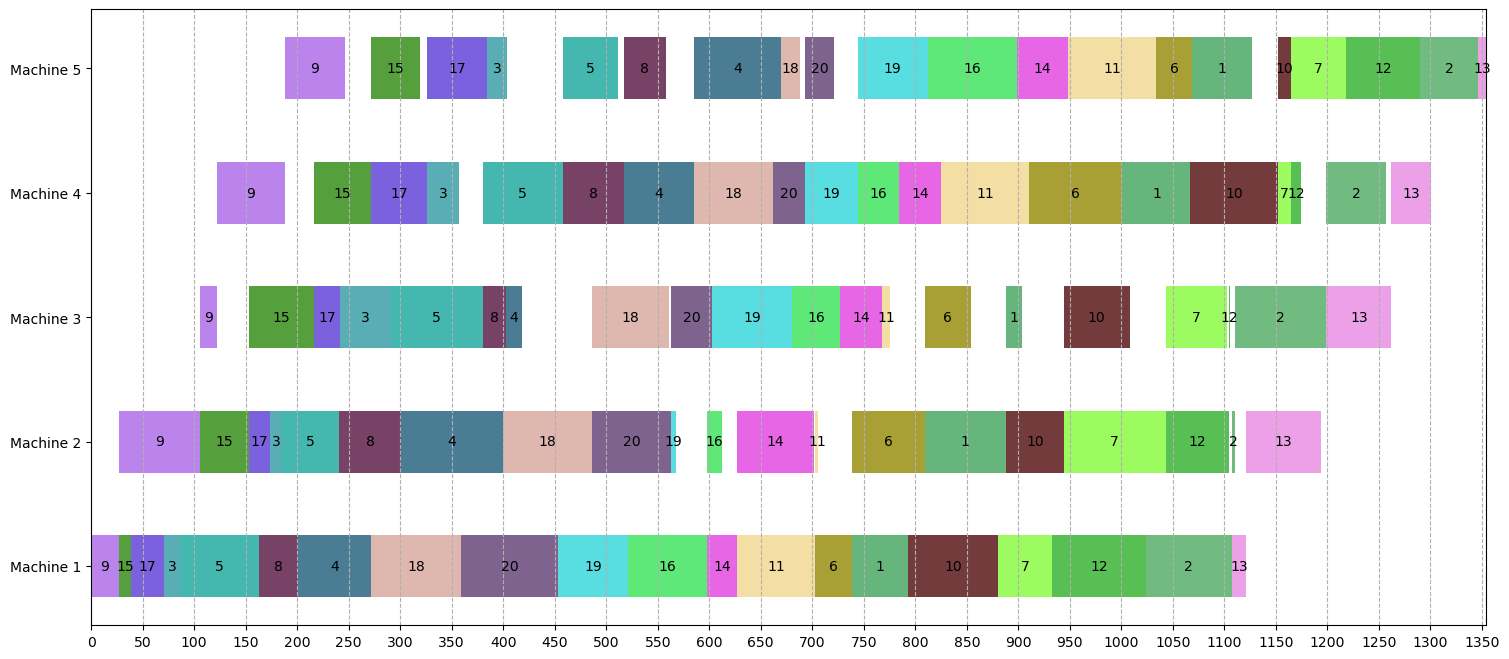

In [27]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [28]:
print('Results of random:')
print(f'First sequence: {permutation} with a makespan of {calculate_makespan(benchmark, permutation)}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of random:
First sequence: [8, 3, 7, 13, 0, 14, 6, 17, 19, 18, 15, 2, 10, 5, 16, 9, 12, 11, 1, 4] with a makespan of 1516.

Results of RS:
Best solution: [14, 16, 12, 0, 3, 2, 10, 18, 7, 8, 4, 13, 5, 15, 1, 6, 9, 17, 11, 19] with a makespan of 1297.

Results of RS_FBA:
Best solution: [8, 14, 16, 2, 4, 7, 3, 17, 19, 18, 15, 13, 10, 5, 0, 9, 6, 11, 1, 12] with a makespan of 1321.
Best global solution: [8, 14, 16, 2, 4, 7, 3, 17, 19, 18, 15, 13, 10, 5, 0, 9, 6, 11, 1, 12] with a makespan of 1321.


### NEH initial solution

#### Without FBA swapping method

In [29]:
initialSolution, makespan = neh_algorithm(benchmark)
rs_solution = RS(benchmark, initialSolution, 5)

init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334 

Elapsed time: 0.09849762916564941 seconds


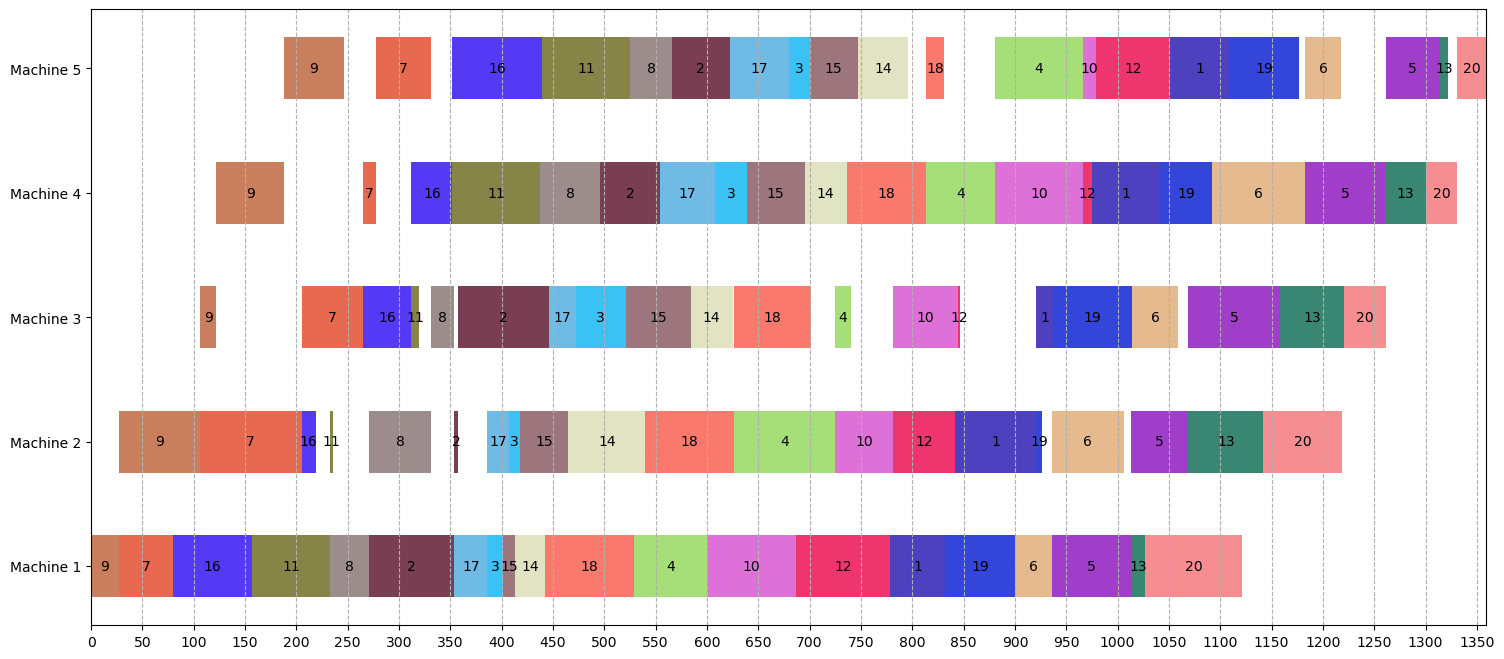

In [30]:
generate_gantt_chart(benchmark, initialSolution)    

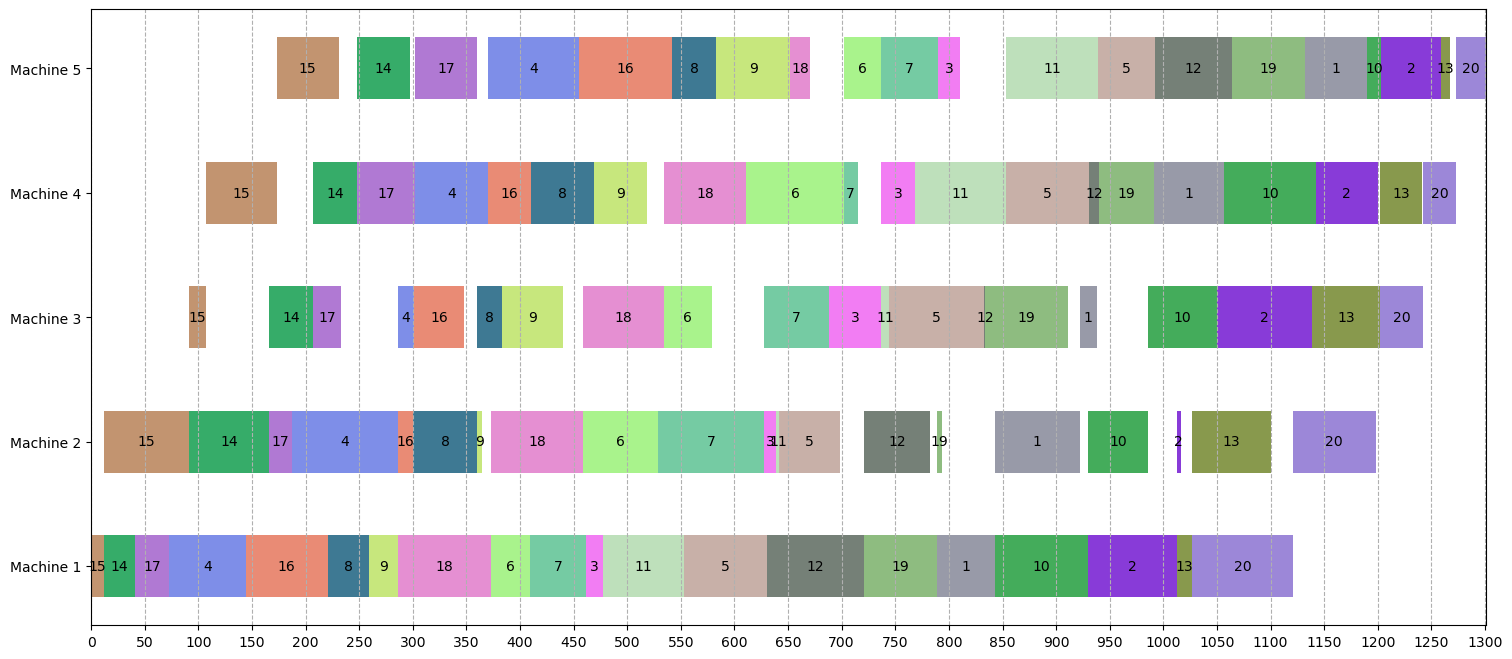

In [31]:
generate_gantt_chart(benchmark, rs_solution)    

#### With FBA swapping method

In [32]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5)

init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334
initial_global_solution:  [6, 8, 16, 7, 12, 19, 17, 14, 9, 1, 10, 2, 11, 4, 0, 15, 3, 5, 13, 18]  global_makespan =  1523 

Elapsed time: 1.4938218593597412 seconds


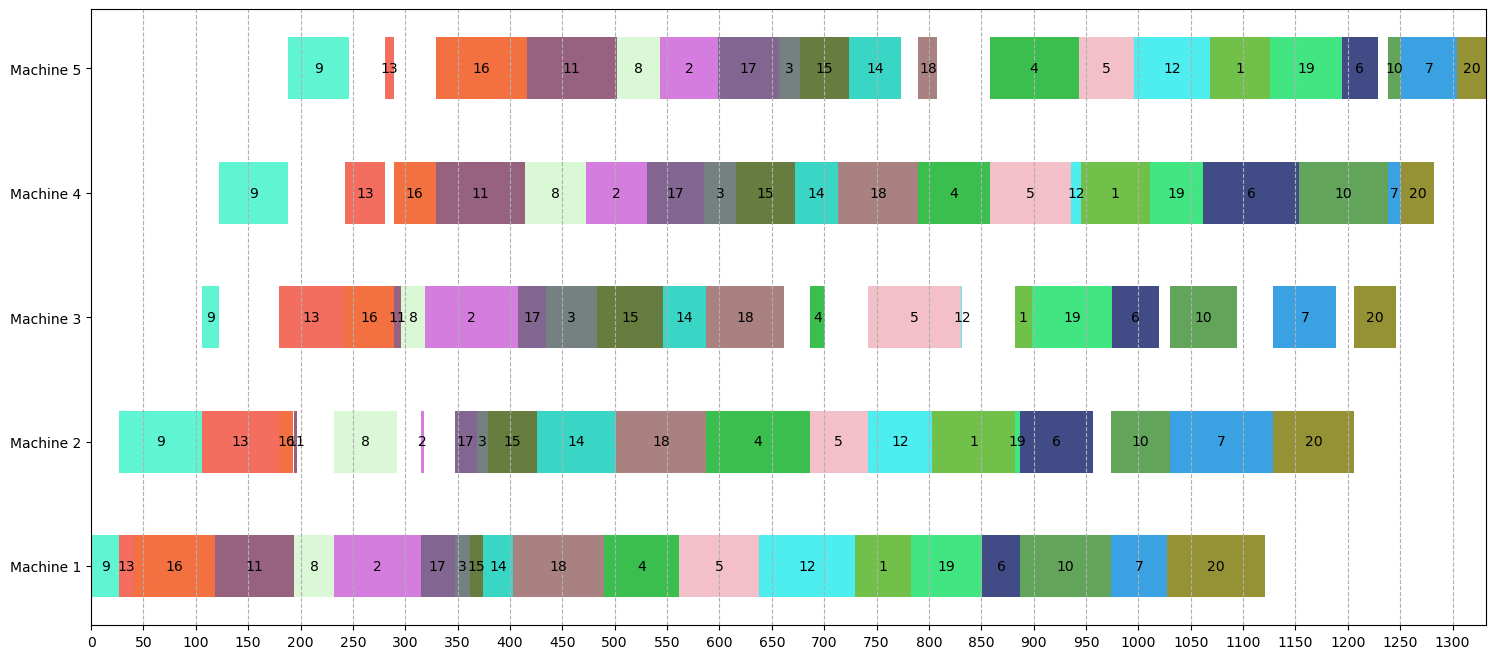

In [33]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [34]:
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of NEH:
First sequence: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.

Results of RS:
Best solution: [14, 13, 16, 3, 15, 7, 8, 17, 5, 6, 2, 10, 4, 11, 18, 0, 9, 1, 12, 19] with a makespan of 1301.

Results of RS_FBA:
Best solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.
Best global solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.


### PRSKE initial solution

#### Without FBA swapping method

In [35]:
initialSolution, makespan  = PRSKE(benchmark)
rs_solution = RS(benchmark, initialSolution, 5)

init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593 

Elapsed time: 0.10753679275512695 seconds


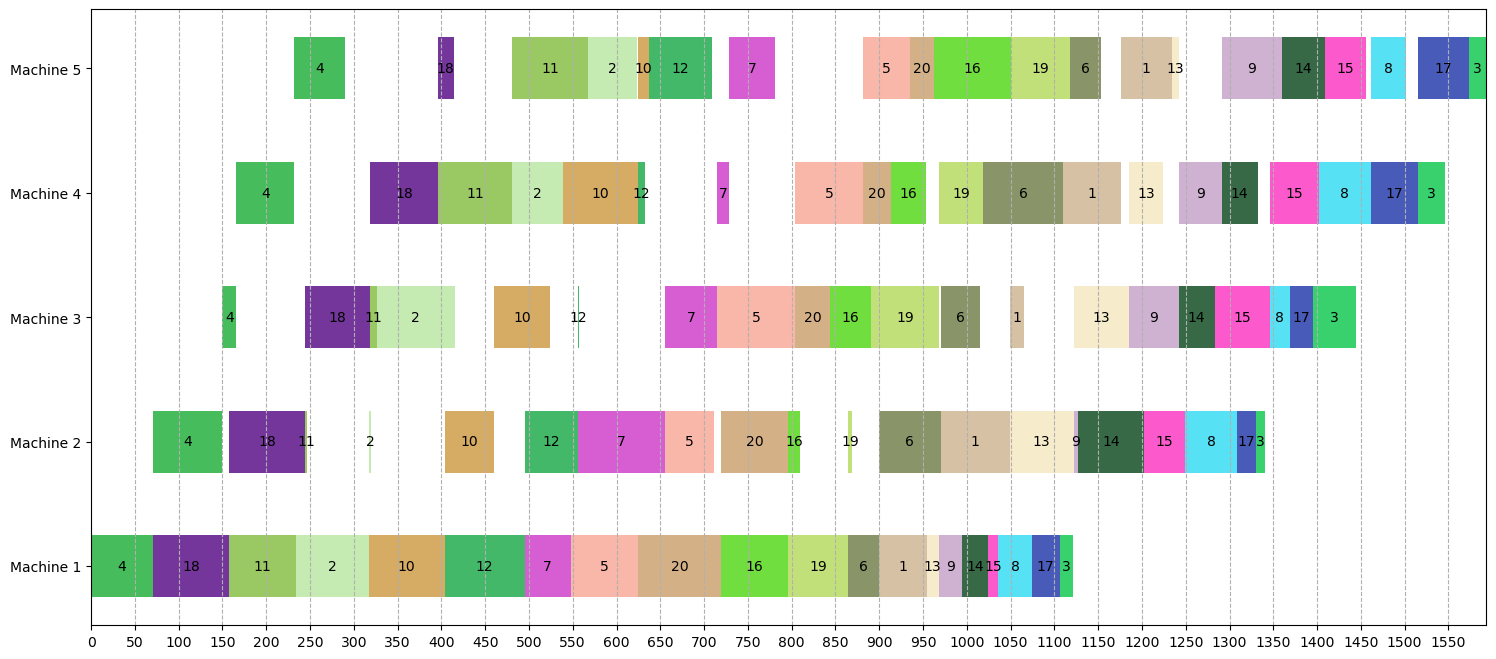

In [36]:
generate_gantt_chart(benchmark, initialSolution)

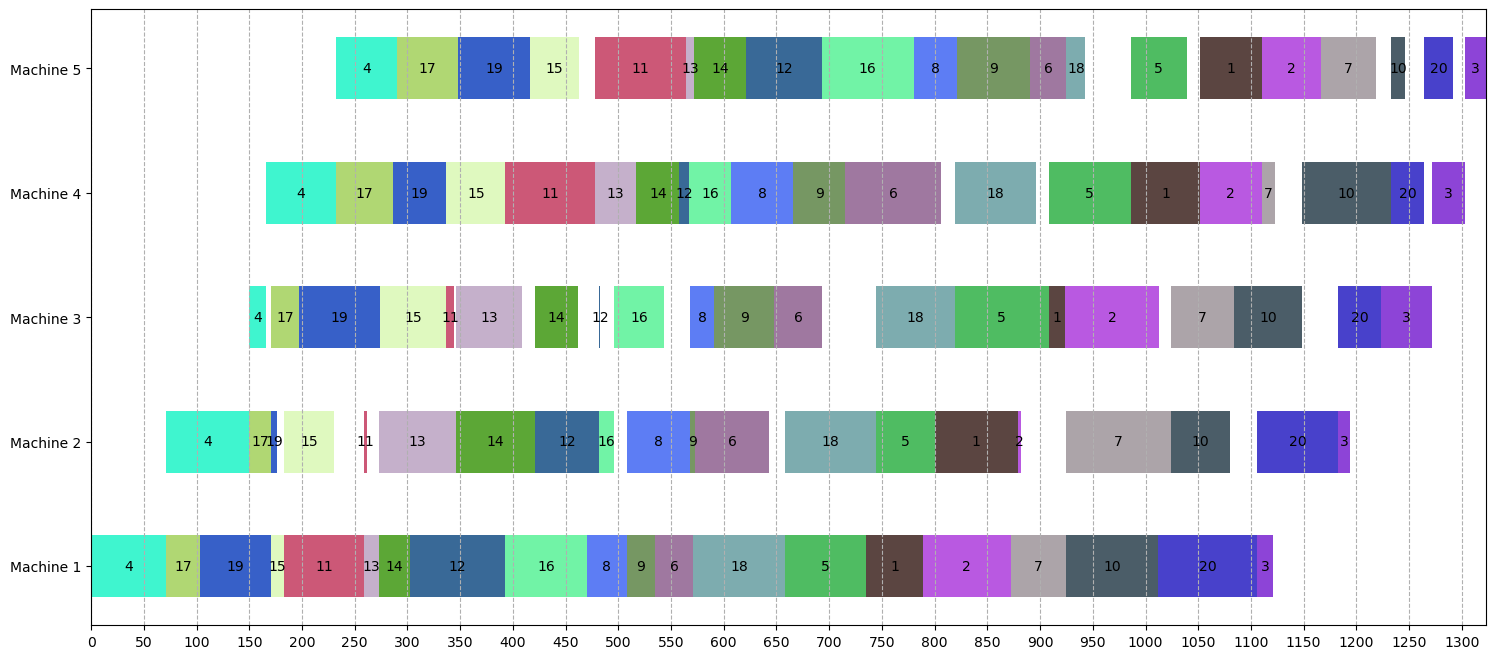

In [37]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [38]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5)

init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593
initial_global_solution:  [6, 8, 16, 7, 12, 19, 17, 14, 9, 1, 10, 2, 11, 4, 0, 15, 3, 5, 13, 18]  global_makespan =  1523 

Elapsed time: 1.297417163848877 seconds


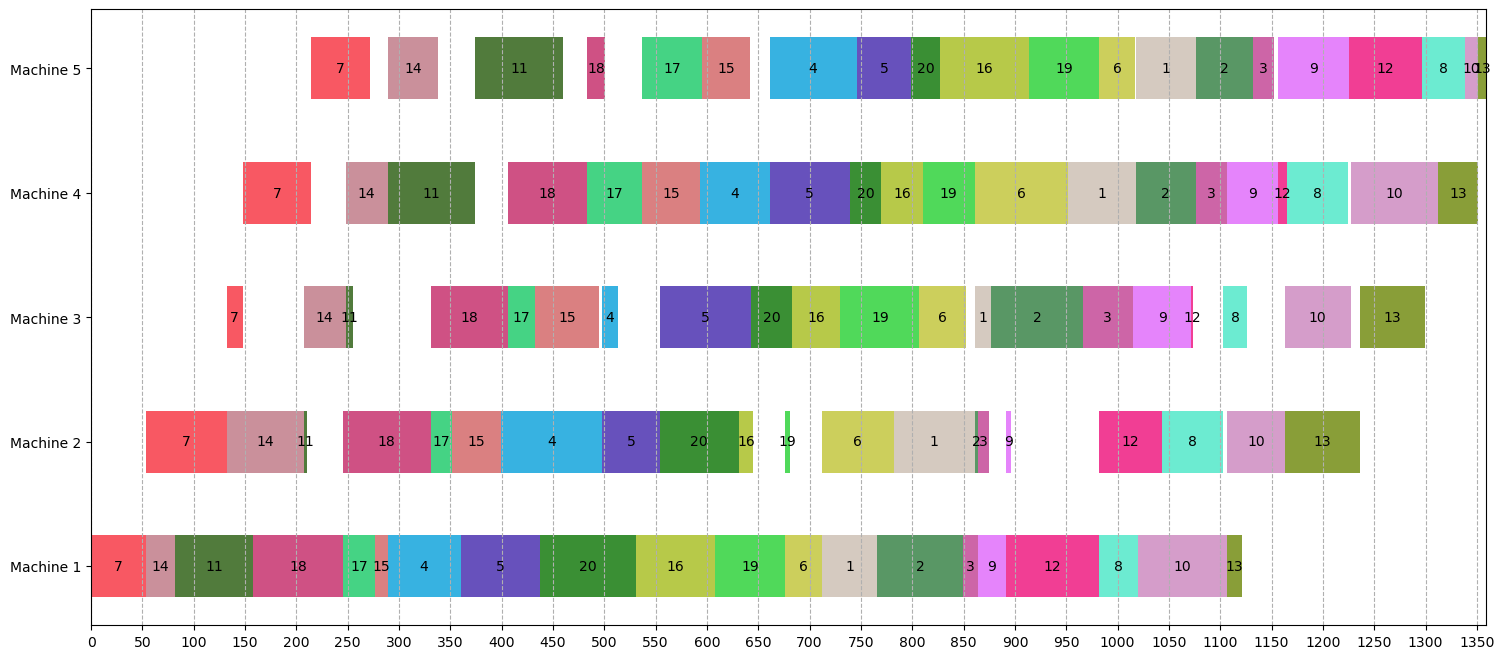

In [39]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [40]:
print('Results of PRSKE:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of PRSKE:
First sequence: [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2] with a makespan of 1593.

Results of RS:
Best solution: [3, 16, 18, 14, 10, 12, 13, 11, 15, 7, 8, 5, 17, 4, 0, 1, 6, 9, 19, 2] with a makespan of 1323

Results of RS_FBA:
Best solution: [6, 13, 10, 17, 16, 14, 3, 4, 19, 15, 18, 5, 0, 1, 2, 8, 11, 7, 9, 12] with a makespan of 1359.
Best global solution: [6, 13, 10, 17, 16, 14, 3, 4, 19, 15, 18, 5, 0, 1, 2, 8, 11, 7, 9, 12] with a makespan of 1359.
